# ElasticNet

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2_STORY_1946_NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2008.0,WD,Normal
1,1_STORY_1946_NEWER_ALL_STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,5.0,2007.0,WD,Normal
2,2_STORY_1946_NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,9.0,2008.0,WD,Normal
3,2_STORY_1945_OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2006.0,WD,Abnorml
4,2_STORY_1946_NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,12.0,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2_STORY_PUD_1946_NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,6.0,2006.0,WD,Normal
2913,2_STORY_PUD_1946_NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,4.0,20

In [3]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
enet_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
enet_feat_eng = [nbrhd_rank, totallivsf_add, bsmtfin_add, totalporchsf_add, yrsremodtosold_add,
                 conditions_edit, drop_grlivarea, drop_bsmtfinsf12, drop_yrsoldremod, drop_fireplaces,
                 drop_baths, drop_bsmtbaths]

for feat in enet_feat_eng:
    feat(enet_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(enet_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_full_strd_to_use

,YrsRemodToSold,TotalPorchSF,BsmtFin,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,NbMedianRank,MSSubClass_1_1_2_STORY_PUD_ALL_AGES,MSSubClass_1_1_2_STORY_UNFINISHED_ALL_AGES,MSSubClass_1_STORY_1945_OLDER,MSSubClass_1_STORY_1946_NEWER_ALL_STYLES,MSSubClass_1_STORY_PUD_(Planned_Unit_Development)_1946_NEWER,MSSubClass_1_STORY_W_FINISHED_ATTIC_ALL_AGES,MSSubClass_2_1_2_STORY_ALL_AGES,MSSubClass_2_FAMILY_CONVERSION_ALL_STYLES_AND_AGES,MSSubClass_2_STORY_1945_OLDER,MSSubClass_2_STORY_1946_NEWER,MSSubClass_2_STORY_PUD_1946_NEWER,MSSubClass_DUPLEX_ALL_STYLES_AND_AGES,MSSubClass_PUD_MULTILEVEL_INCL_SPLIT_LEV_FOYER,MSSubClass_SPLIT_FOYER,MSSubClass_SPLIT_OR_MULTI_LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.083333,0.050539,1.0,0.237373,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.166667,0.064212,0.168008,1.00,1.0,1.00,0.109641,0.413559,0.0,0.375,0.333333,0.666667,0.461538,1.000000,0.996517,0.666667,0.4,0.368280,0.6,0.6,1.0,0.000000,0.082210,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.090909,0.458333,0.0,0

In [4]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

## Trying w ElasticNet

In [5]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 3min 4s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.926533,0.931848,0.107431,0.107471,-0.00004,0.001,0.5,0,True


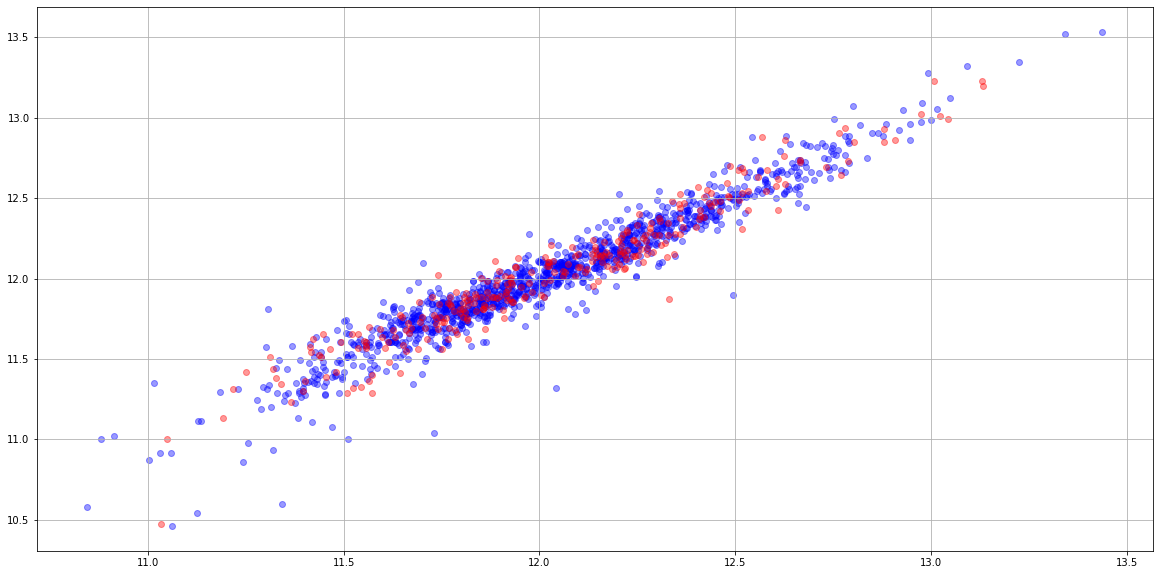

In [6]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [7]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 2min 30s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.930034,0.934131,0.10484,0.105655,-0.000815,0.0005,0.75,0,True


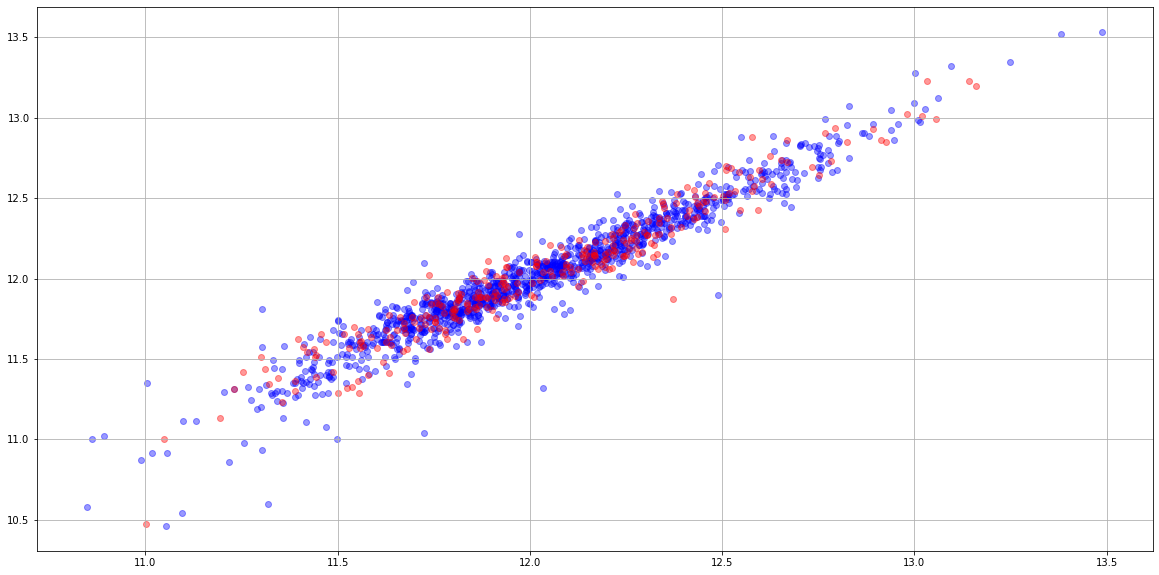

In [8]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [9]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 3min 1s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.929702,0.93448,0.105089,0.105376,-0.000286,0.0004,1,0,True


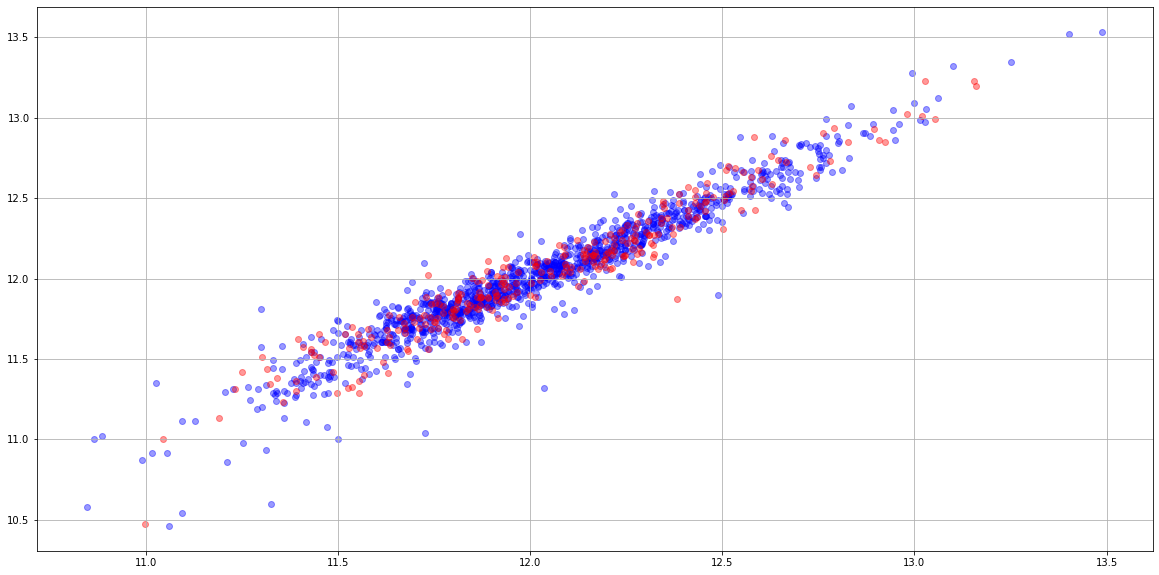

In [10]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [11]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [3e-4, 3.25e-4, 3.5e-4, 3.75e-4, 4e-4, 4.25e-4, 4.5e-4, 4.75e-4, 5e-4]
l1ratio = [0.8, 0.9, 1]
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 1.39 s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.929504,0.934043,0.105237,0.105726,-0.00049,0.00045,0.9,0,True


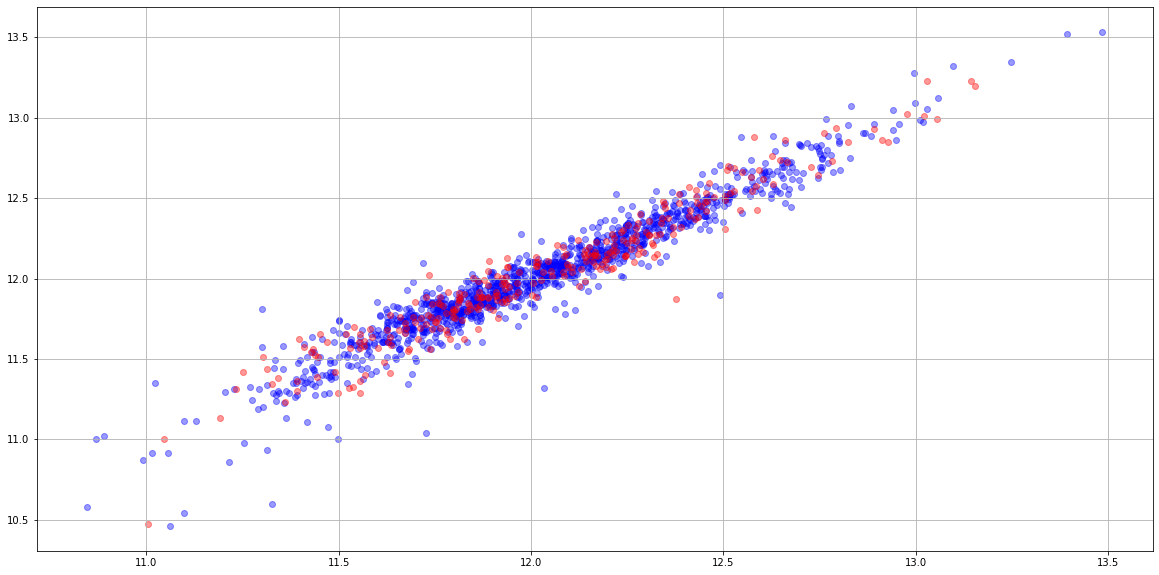

In [12]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [13]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = np.linspace(4e-4, 5e-4, 41)
l1ratio = np.linspace(8e-1, 1, 41)
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 59 s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.929369,0.934025,0.105338,0.105741,-0.000403,0.000455,0.905,0,True


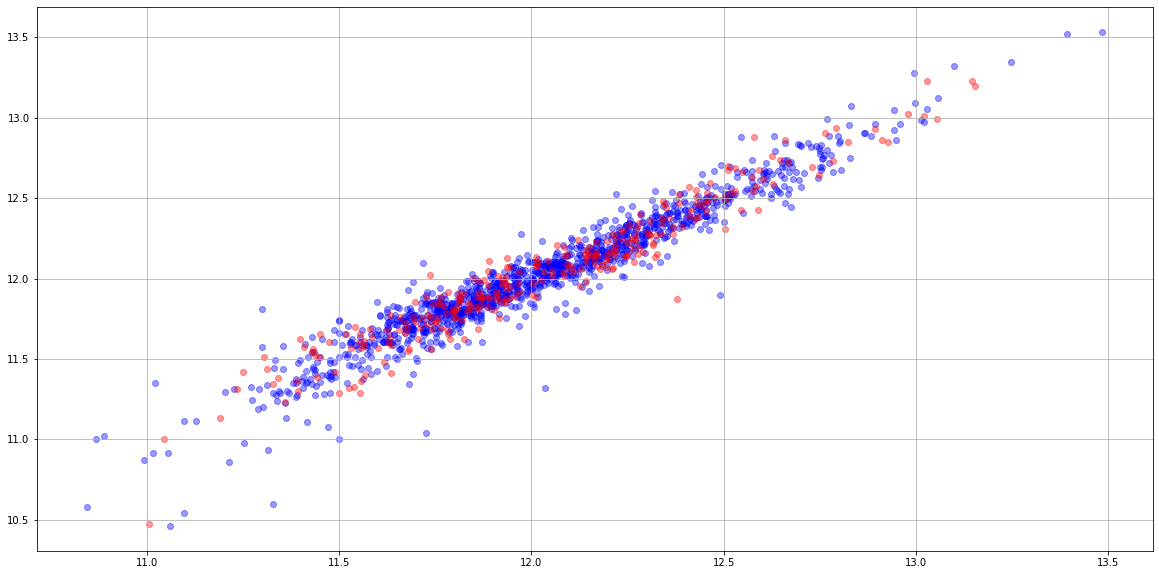

In [14]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_1.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_1.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [15]:
# Most important features
enet_coef_strd = pd.Series(gs_enet_1.best_estimator_.coef_, index=hp_full_strd_to_use.columns)

# Getting df with most important features only
enet_coef_index_01 = [i for i, x in enumerate(enet_coef_strd) if abs(x) > 0]

hp_enet_strd_reduced = hp_full_strd.iloc[:,enet_coef_index_01]

# columns that were dropped by enet

enet_coef_index_00 = [i for i, x in enumerate(enet_coef_strd) if abs(x) == 0]
hp_enet_strd_dropped = hp_full_strd.iloc[:, enet_coef_index_00]

hp_enet_strd_dropped_rdc = copy.deepcopy(hp_enet_strd_dropped.iloc[hp_index])

hp_enet_strd_dropped_rdc

,Alley,Utilities,ExterCond,BsmtCond,TotalBsmtSF,Electrical,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,GarageYrBlt,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,PoolQC,MiscVal,NbMedianRank,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_RH,MSZoning_RM,LotShape_IR3,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_FR2,LotConfig_FR3,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_Gilbert,Neighborhood_NPkVill,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_Duplex,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_VinylSd,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_VinylSd,Foundation_CBlock,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_TA,GarageType_CarPort,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Jan,MoSold_Mar,MoSold_Oct,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
0,0.0,1.0,0.50,0.75,0.168008,1.00,0.0,0.375,0.333333,0.996517,0.082210,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.50,0.75,0.247694,1.00,0.0,0.375,0.333333,0.983085,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.50,0.75,0.180569,1.00,0.0,0.375,0.333333,0.995522,0.056604,0.000000,0.0,0.0,0.0,0.000000,0.458333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.50,1.00,0.148381,1.00,0.0,0.375,0.333333,0.994030,0.047170,0.268775,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [16]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# setting up train_enet and test_enet sets
xtrain_enet, xtest_enet, ytrain_enet, ytest_enet = ms.train_test_split(hp_enet_strd_dropped_rdc,
                                                                       hp_logsp,
                                                                       test_size=0.2,
                                                                       random_state=0)

# Must flatten to fit
ytrain_enet = ytrain_enet.values.flatten()

# parameters to use
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_rdc = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_rdc = ms.GridSearchCV(enet, gparam_enet_rdc, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_rdc.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_rdc.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_rdc.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_rdc, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_rdc, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_rdc.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 3min 10s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.926533,0.931848,0.107431,0.107471,-0.00004,0.001,0.5,0,True


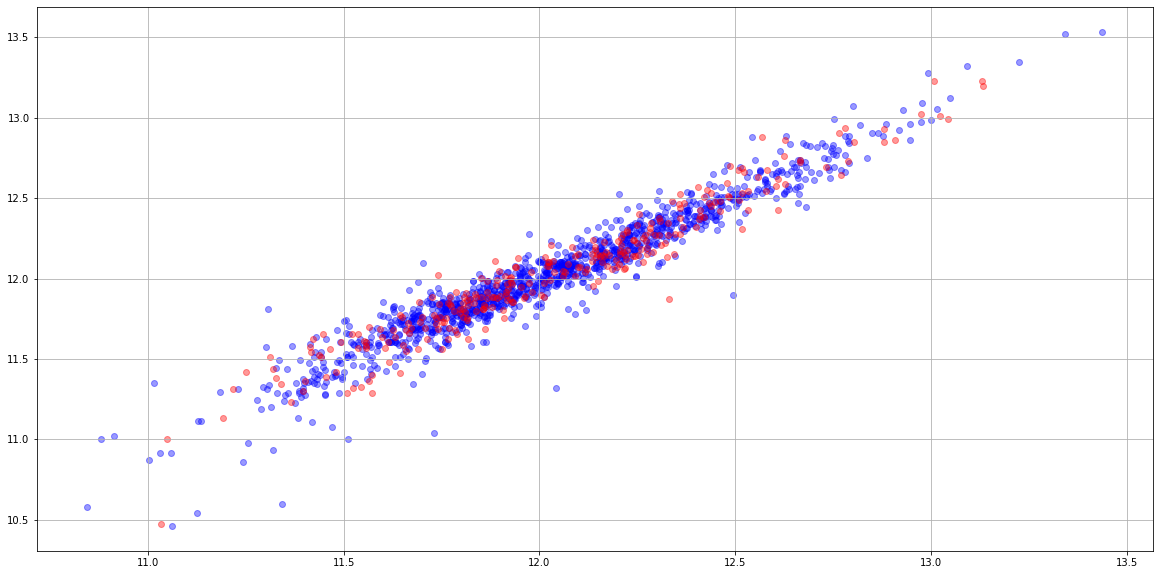

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_rdc.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_rdc.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [18]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# setting up train_enet and test_enet sets
xtrain_enet, xtest_enet, ytrain_enet, ytest_enet = ms.train_test_split(hp_enet_strd_dropped_rdc,
                                                                       hp_logsp,
                                                                       test_size=0.2,
                                                                       random_state=0)

# Must flatten to fit
ytrain_enet = ytrain_enet.values.flatten()

# parameters to use
alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0015]
l1ratio = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
warmstart = [True]

gparam_enet_rdc = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_rdc = ms.GridSearchCV(enet, gparam_enet_rdc, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_rdc.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_rdc.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_rdc.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_rdc, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_rdc, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_rdc.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 7.22 s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.929702,0.93448,0.105089,0.105376,-0.000286,0.0004,1,0,True


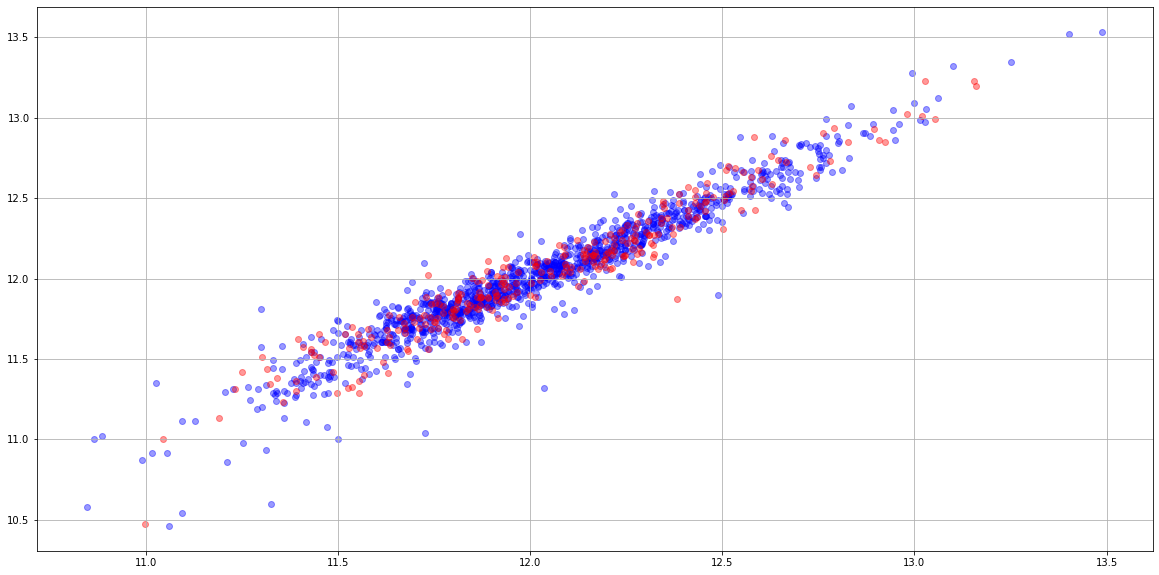

In [19]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_rdc.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_enet_rdc.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

# although the above score is not THE best, the test and train RMSEs are close

In [20]:
enet_experimental = copy.deepcopy(enet_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
          'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

enet_df = enet_df.drop(['MoSold'], axis=1)

new_cols = list(enet_df.columns) + list(to_paste.columns)

enet_experiment = pd.DataFrame(np.concatenate((enet_df.loc[hp_index], to_paste.loc[hp_index]),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in enet_experiment.columns: 
    enet_experiment[col] = enet_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(enet_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

hp_experimental_to_use

,YrsRemodToSold,TotalPorchSF,BsmtFin,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,NbMedianRank,DateSold,WSJPrime,YrSold,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRA,Condition1_RRN,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRA,Condition2_RRN,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,0.083333,0.059396,1.0,0.333761,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.166667,0.064212,0.266999,1.00,1.0,1.00,0.180373,0.413559,0.0,0.375,0.333333,0.666667,0.500000,1.0000

In [21]:
state = 0

# setting up train and test sets
xtrain_exp, xtest_exp, ytrain_exp, ytest_exp = ms.train_test_split(hp_experimental_to_use,
                                                                   hp_logsp,
                                                                   test_size=0.2,
                                                                   random_state=state)

# Must flatten to fit
ytrain_exp = ytrain_exp.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [22]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 0, 1, 10]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_exp = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_exp = ms.GridSearchCV(enet, gparam_enet_exp, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_enet_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_enet_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_enet_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_enet_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 3min 13s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,random_state,warm_start
0,0.927842,0.933927,0.10647,0.105819,0.000651,0.001,0.5,0,True


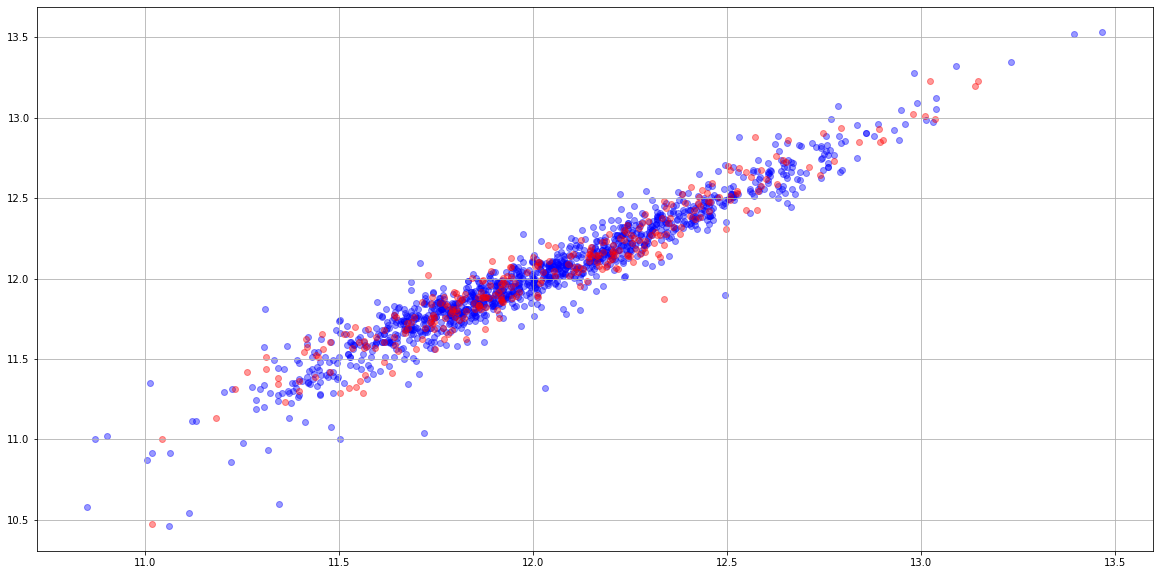

In [23]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_enet_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [ ]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.002, 0.003, 0.004, 0.005]
l1ratio = [0, 0.25, 0.5, 0.75, 1]
warmstart = [True]

gparam_enet_exp = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_exp = ms.GridSearchCV(enet, gparam_enet_exp, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_enet_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_enet_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_enet_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_enet_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

In [ ]:
plt.figure(figsize=(20, 10))
plt.scatter(gs_enet_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_enet_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

# BEST PARAM

In [ ]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
enet_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
enet_feat_eng = [nbrhd_rank, totallivsf_add, bsmtfin_add, totalporchsf_add, yrsremodtosold_add,
                 conditions_edit, drop_grlivarea, drop_bsmtfinsf12, drop_yrsoldremod, drop_fireplaces,
                 drop_baths, drop_bsmtbaths]

for feat in enet_feat_eng:
    feat(enet_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(enet_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

enet = enet(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = [0.000455]
l1ratio = [0.905]
warmstart = [True]

gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# Most important features
enet_coef_strd = pd.Series(gs_enet_1.best_estimator_.coef_, index=hp_full_strd_to_use.columns)

# Getting df with most important features only
enet_coef_index_01 = [i for i, x in enumerate(enet_coef_strd) if abs(x) > 0]

hp_enet_strd_reduced = hp_full_strd.iloc[:,enet_coef_index_01]

# columns that were dropped by enet

enet_coef_index_00 = [i for i, x in enumerate(enet_coef_strd) if abs(x) == 0]
hp_enet_strd_dropped = hp_full_strd.iloc[:, enet_coef_index_00]

hp_enet_strd_dropped_rdc = copy.deepcopy(hp_enet_strd_dropped.iloc[hp_index])

# parameters to use
alphas = [0.0004]
l1ratio = [1]
warmstart = [True]

gparam_enet_rdc = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart,
                 'random_state': [state]}

# setting parameters
gs_enet_rdc = ms.GridSearchCV(enet, gparam_enet_rdc, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_rdc.fit(xtrain, ytrain)

In [5]:
# from 1st model runthru

# make copies of the original df to edit each individually according to the best scores/feat eng pair
enet_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
enet_feat_eng = [nbrhd_rank, totallivsf_add, bsmtfin_add, totalporchsf_add, yrsremodtosold_add,
                 conditions_edit, drop_grlivarea, drop_bsmtfinsf12, drop_yrsoldremod, drop_fireplaces,
                 drop_baths, drop_bsmtbaths]

for feat in enet_feat_eng:
    feat(enet_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(enet_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2, 
                                                   random_state=state)
# Must flatten to fit
ytrain = ytrain.values.flatten()

enet = ElasticNet(max_iter=10000000, selection='random', random_state=0)
# parameters to use
alphas = [0.0001]
l1ratio = [0.75, 1]
warmstart = [True]
gparam_enet_3 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart}
# setting parameters
gs_enet_3 = ms.GridSearchCV(enet, gparam_enet_3, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', 
                            return_train_score=True)
gs_enet_3.fit(x_trn, y_trn)
enet_model_3.test_rmse = rmse(gs_enet_3, y_tst, x_tst)

NameError: name 'x_trn' is not defined

In [7]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
# parameters to use
alphas = [0.0001]
l1ratio = [0.75, 1]
warmstart = [True]
gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_enet_1.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_enet_1.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_enet_1, ytrain, xtrain))
test_rmse.append(rmse(gs_enet_1, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_enet_1.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
enet_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
enet_res_df = pd.DataFrame(enet_list_results).T
enet_res_df.columns = ['TrainScores', 'TestScores', 'trainRMSE', 'testRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
enet_res_df = pd.concat([enet_res_df, best_par_df], axis=1, sort=False)

enet_res_df

Wall time: 1.57 s


,TrainScores,TestScores,trainRMSE,testRMSE,DiffRMSE,alpha,l1_ratio,warm_start
0,0.939293,0.939874,0.097657,0.100945,-0.003288,0.0001,1,True
